In [1]:
import os, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Reproducibilidad y preparación de datos

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

transform = transforms.Compose([
    transforms.ToTensor(),                # [0,1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

## Modelo Autoencoder

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: (N,1,28,28) -> (N,64,1,1)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # (N,16,14,14)
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # (N,32,7,7)
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 7),                      # (N,64,1,1)
        )
        # Decoder: (N,64,1,1) -> (N,1,28,28)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),                                        # (N,32,7,7)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # (N,16,14,14)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1,  3, stride=2, padding=1, output_padding=1), # (N,1,28,28)
            nn.Sigmoid()  
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)            # -> (N,1,28,28)
        return out

model = Autoencoder().to(device)

## Entrenamiento

In [4]:
# Ruido Gaussiano + Peak Signal-to-Noise Ratio (PSNR)
def add_noise(image, noise_level=0.4):
    noise = torch.randn_like(image) * noise_level
    noisy = image + noise
    return torch.clamp(noisy, 0.0, 1.0)

def psnr(img1, img2, eps=1e-10):
    # img1, img2 en [0,1]
    mse = torch.mean((img1 - img2) ** 2).clamp_min(eps)
    return 20.0 * torch.log10(1.0 / torch.sqrt(mse))


# Entrenamiento
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

model.train()
for epoch in range(1, num_epochs+1):
    epoch_loss = 0.0
    epoch_psnr = 0.0
    n_batches = 0

    for img, _ in train_loader:
        img = img.to(device)                          # (N,1,28,28) en [0,1]
        noisy_img = add_noise(img)                    # mismo tamaño

        recon = model(noisy_img)                      # (N,1,28,28)

        loss = criterion(recon, img)                  # comparar directamente con el original
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Métricas promediadas
        with torch.no_grad():
            batch_psnr = psnr(recon.detach(), img).item()
        epoch_loss += loss.item()
        epoch_psnr += batch_psnr
        n_batches += 1

    print(f"Epoch {epoch:02d}/{num_epochs} | Loss: {epoch_loss/n_batches:.4f} | PSNR: {epoch_psnr/n_batches:.2f} dB")


Epoch 01/10 | Loss: 0.0416 | PSNR: 14.68 dB
Epoch 02/10 | Loss: 0.0135 | PSNR: 18.73 dB
Epoch 03/10 | Loss: 0.0108 | PSNR: 19.67 dB
Epoch 04/10 | Loss: 0.0098 | PSNR: 20.11 dB
Epoch 05/10 | Loss: 0.0092 | PSNR: 20.36 dB
Epoch 06/10 | Loss: 0.0089 | PSNR: 20.50 dB
Epoch 07/10 | Loss: 0.0087 | PSNR: 20.61 dB
Epoch 08/10 | Loss: 0.0085 | PSNR: 20.70 dB
Epoch 09/10 | Loss: 0.0084 | PSNR: 20.77 dB
Epoch 10/10 | Loss: 0.0083 | PSNR: 20.82 dB


## Evaluación

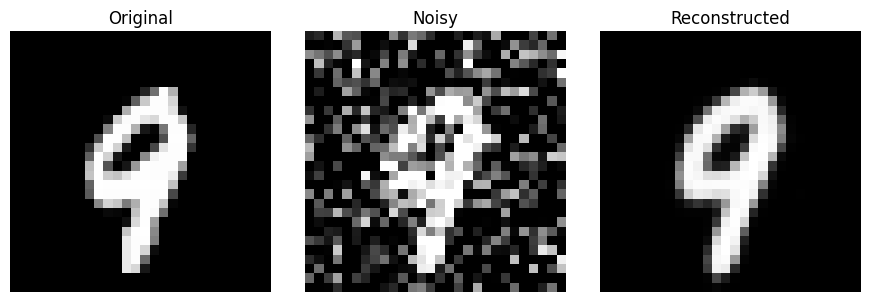

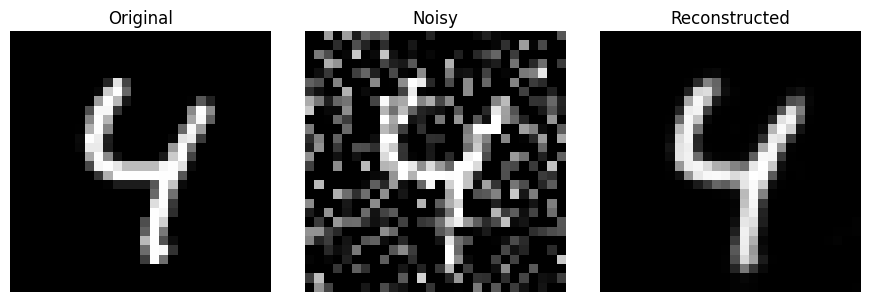

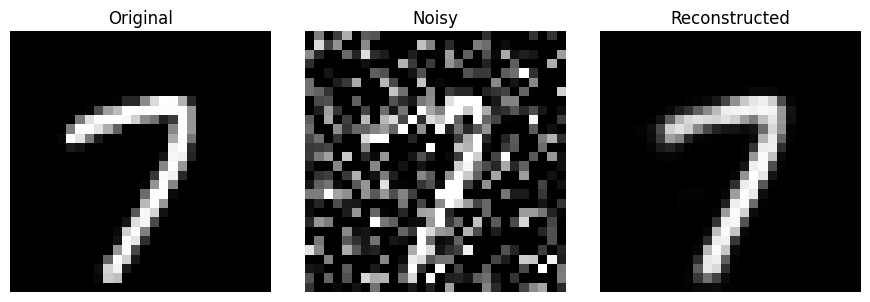

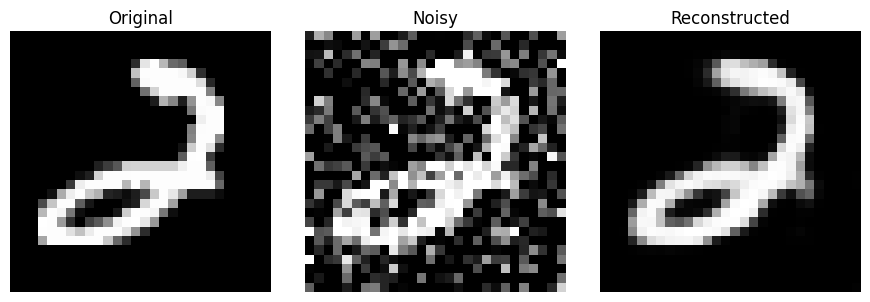

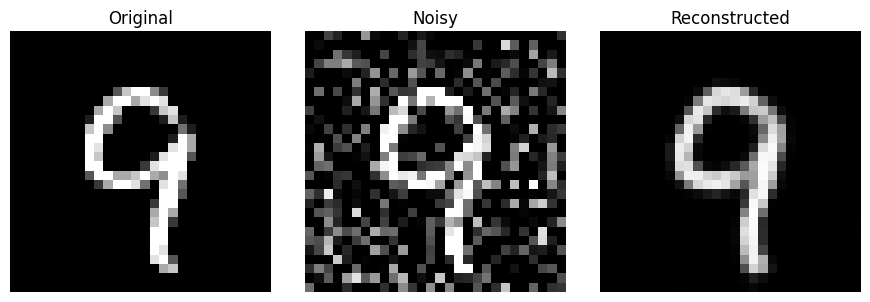

In [5]:
model.eval()
with torch.no_grad():
    for _ in range(5):
        img, _ = random.choice(train_dataset)   # tensor [1,28,28] en [0,1]
        img = img.unsqueeze(0).to(device)       # (1,1,28,28)
        noisy = add_noise(img)                  # (1,1,28,28)
        recon = model(noisy)                    # (1,1,28,28)

        plt.figure(figsize=(9,3))
        plt.subplot(1,3,1); plt.imshow(img.squeeze(0).squeeze(0).cpu(), cmap='gray');   plt.title('Original');    plt.axis('off')
        plt.subplot(1,3,2); plt.imshow(noisy.squeeze(0).squeeze(0).cpu(), cmap='gray'); plt.title('Noisy');       plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(recon.squeeze(0).squeeze(0).cpu(), cmap='gray'); plt.title('Reconstructed'); plt.axis('off')
        plt.tight_layout(); plt.show()
